# Oversampling on class + more Grid search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

Importing datasets manually

In [2]:
df_red = pd.read_csv('../winequality-red.csv', sep=';')

df_white = pd.read_csv('../winequality-white.csv', sep=';')

I add a color column to the datasets

In [3]:
df_red['color'] = 0    # per red
df_white['color'] = 1  # per white

df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


i'm applying oversampling to the red dataset so it does not have a lot less values than white

In [4]:

X_red = df_red.drop(columns='quality')
y_red = df_red['quality']

smote = SMOTE(random_state=42)
X_red_resampled, y_red_resampled = smote.fit_resample(X_red, y_red)

I concatenate the red and white datasets to have a single one

In [5]:
red_wine_resampled = pd.concat([
    pd.DataFrame(X_red_resampled, columns=X_red.columns),
    pd.Series(y_red_resampled, name='quality')
], axis=1)

data = pd.concat([red_wine_resampled, df_white], ignore_index=True)

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,6
8980,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1,5
8981,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,6
8982,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,7


## Regrouping the target classes

3--4 $\rightarrow$ 1;   
5 $\rightarrow$ 2;  
6 $\rightarrow$ 3;  
7--8--9 $\rightarrow$ 4;    



In [6]:
data['quality'] = data['quality'].replace({
    3: 1, 4: 1,
    5: 2,
    6: 3,
    7: 4, 8: 4, 9: 4
})


In [7]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,3
8980,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1,2
8981,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,3
8982,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,4


## Expolaratory Data analysis

We start with a pie chart to look at the proportion of quality levels

The distribution looks acceptable, but I will try applying oversampling to balance the number of occurrences across the different quality categories.

### SMOTE

In [8]:
X = data.drop(columns='quality')
y = data['quality']
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
5526,7.200000,0.260000,0.740000,13.600000,0.050000,56.000000,162.000000,0.998000,3.030000,0.440000,8.800000,1
8499,5.800000,0.300000,0.380000,4.900000,0.039000,22.000000,86.000000,0.989630,3.230000,0.580000,13.100000,1
5489,7.100000,0.260000,0.310000,2.200000,0.044000,29.000000,128.000000,0.993700,3.340000,0.640000,10.900000,1
9500,7.301251,1.158764,0.029875,4.250994,0.104138,3.805003,11.987492,0.996744,3.440250,0.471700,10.481751,0
9405,7.337425,0.422024,0.451081,2.521652,0.071196,23.223596,84.050106,0.996978,3.347914,0.685645,9.658197,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,9.370473,0.304076,0.555753,2.792598,0.079920,6.060149,17.017456,0.996328,3.151042,0.916179,11.722155,0
5191,5.500000,0.320000,0.450000,4.900000,0.028000,25.000000,191.000000,0.992200,3.510000,0.490000,11.500000,1
5390,8.000000,0.590000,0.710000,17.350000,0.038000,61.000000,228.000000,1.000000,2.950000,0.750000,9.300000,1
860,7.200000,0.620000,0.060000,2.700000,0.077000,15.000000,85.000000,0.997460,3.510000,0.540000,9.500000,0


We can see that the number of observations is now balanced across all classes, indicating that the data has been successfully rescaled using SMOTE.

## PCA

In [9]:
X_scaled = X_resampled.copy()

cols_to_scale = X_scaled.columns.difference(['color'])

scaler = StandardScaler()

X_scaled[cols_to_scale] = scaler.fit_transform(X_scaled[cols_to_scale])

In [10]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# EXPERIMENTS
We start by looking at the best performing models w/o optmization.
First we load the models

We then scale the sets

And now we train all the models to select the best performing ones.

Since we only found accuracy >= 0.67 for MLP, SVM and decision trees we are going to grid search only on those

We obtained strong results across all models, and the MLP seems to have the best performance with 75% of average accuracy. Next, we'll look at the test set accuracy to assess whether the model is overfitting.

The difference between training and testing accuracy is small, which suggests that the model is reliable.

In conclusion, the best model found using SMOTE oversampling is a Multi-Layer Perceptron with two hidden layers (the first with 100 neurons and the second with 50) and alpha value of 0.0001

It achieved a testing accuracy of 75%.

## More aggressive Grid search with SMOTE

ora ho tolto l'output, l'ultimo non si riferiva a questa configurazione. 


Qui ho avuto questi risultati: 

Best hyperparams:  {'mlp__activation': 'tanh', 'mlp__alpha': 2.458603276328006e-05, 'mlp__hidden_layer_sizes': (150, 100, 50), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.0020914981329035616, 'mlp__solver': 'adam'}


Accuracy test set: 0.7860243055555556

Classification Report:               precision    recall  f1-score   support

           1       0.93      0.94      0.94       583
           2       0.73      0.70      0.71       565
           3       0.66      0.64      0.65       586
           4       0.82      0.86      0.84       570

    accuracy                           0.79      2304
   macro avg       0.78      0.79      0.78      2304
weighted avg       0.78      0.79      0.78      2304

In [11]:
debug = False
if debug:
    
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import loguniform
    from sklearn.pipeline import Pipeline
    import warnings

    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)


    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter=1000, random_state=42))
    ])

    param_dist = {
        'mlp__hidden_layer_sizes': [(128, 64), (100, 50), (128, 64, 32)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': loguniform(1e-5, 1e-1),
        'mlp__learning_rate': ['constant', 'adaptive'],
        'mlp__learning_rate_init': loguniform(1e-4, 1e-1)
    }

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=100,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=123,
        verbose=3
    )

    random_search.fit(X_train, y_train)

    y_pred = random_search.best_estimator_.predict(X_test)

    print("Best hyperparams: ", random_search.best_params_)
    print("Accuracy test set:", accuracy_score(y_test, y_pred))
    print("Classification Report:", classification_report(y_test, y_pred))

    from pickle import dump, load
    dump(random_search.best_estimator_, open('mlp_model.pkl', 'wb'))
    dump(scaler, open('scaler.pkl', 'wb'))


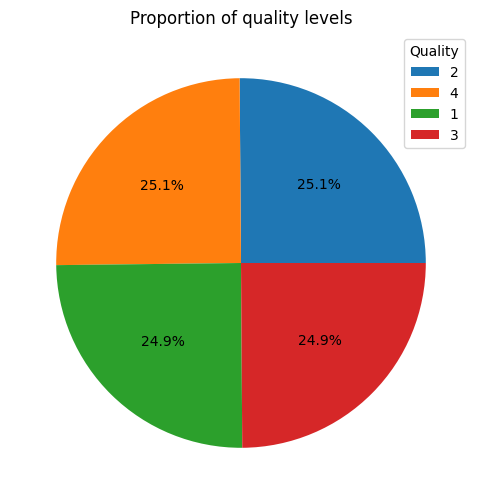

Best hyperparameters after RandomizedSearchCV:
{'activation': 'relu', 'alpha': np.float64(0.008013508750140624), 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.04584154780136381), 'solver': 'sgd'}
Random state: 0


NameError: name 'X_train_scaled' is not defined

In [12]:
# voglio controllare la pie chart della distribuzione delle classi
count = y_train.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

best_params = {'mlp__activation': 'relu', 
               'mlp__alpha': np.float64(0.008013508750140624), 
               'mlp__hidden_layer_sizes': (128, 64, 32), 
               'mlp__learning_rate': 'adaptive', 
               'mlp__learning_rate_init': np.float64(0.04584154780136381),
                 'mlp__solver': 'sgd'
                 }
best_params = {k.split('__')[1]: v for k, v in best_params.items()}

best_acc = 0
best_seed = 0
best_model = None

print("Best hyperparameters after RandomizedSearchCV:")
print(best_params)
for seed in [0, 7, 21, 42, 99, 123, 2024]:
    print(f"Random state: {seed}")

    mlp = MLPClassifier(
        **best_params,
        max_iter=2000,
        random_state=seed
    )

    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    if acc >= 0.8:
        print(f"Random state {seed} achieved accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
    if acc > best_acc:
        best_acc = acc
        best_seed = seed
        best_model = mlp

print(f"Best accuracy test: {best_acc:.4f}")
print(classification_report(y_test, y_pred))
print("Dumping model...")
dump(best_model, open('best_mlp_model.pkl', 'wb'))
dump(scaler, open('best_scaler.pkl', 'wb'))



In [ ]:
mik_best_params = {
    'mlp__activation': 'relu', 
    'mlp__alpha': np.float64(0.0004011862794096692), 
    'mlp__hidden_layer_sizes': (150, 100, 50), 
    'mlp__learning_rate': 'adaptive', 
    'mlp__learning_rate_init': np.float64(0.008331078646805596), 
    'mlp__solver': 'sgd'
}

gea_best_params = {
    'mlp__activation': 'tanh', 
    'mlp__alpha': 2.458603276328006e-05,
    'mlp__hidden_layer_sizes': (150, 100, 50),
    'mlp__learning_rate': 'adaptive',
    'mlp__learning_rate_init': 0.0020914981329035616,
    'mlp__solver': 'adam'


}

last_colab = {
    'mlp__activation': 'relu', 
    'mlp__alpha': np.float64(0.008013508750140624), 
    'mlp__hidden_layer_sizes': (128, 64, 32), 
    'mlp__learning_rate': 'adaptive', 
    'mlp__learning_rate_init': np.float64(0.04584154780136381), 
    'mlp__solver': 'sgd'
}


In [ ]:
"""
best_params = {
    'mlp__activation': 'relu', 
    'mlp__alpha': np.float64(0.0004011862794096692), 
    'mlp__hidden_layer_sizes': (150, 100, 50), 
    'mlp__learning_rate': 'adaptive', 
    'mlp__learning_rate_init': np.float64(0.008331078646805596), 
    'mlp__solver': 'sgd'
}

seed = 123
acc = 0.7982

-----
Random state: 21
Accuracy test: 0.7934
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       583
           2       0.74      0.72      0.73       565
           3       0.65      0.65      0.65       586
           4       0.83      0.85      0.84       570

    accuracy                           0.79      2304
   macro avg       0.79      0.79      0.79      2304
weighted avg       0.79      0.79      0.79      2304
max_iter reached after 2000 epochs


mik_last_colab = {'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.02229519051849171), 'mlp__hidden_layer_sizes': (128, 64), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': np.float64(0.033653273331619556), 'mlp__solver': 'sgd'}
"""

"\nbest_params = {\n    'mlp__activation': 'relu', \n    'mlp__alpha': np.float64(0.0004011862794096692), \n    'mlp__hidden_layer_sizes': (150, 100, 50), \n    'mlp__learning_rate': 'adaptive', \n    'mlp__learning_rate_init': np.float64(0.008331078646805596), \n    'mlp__solver': 'sgd'\n}\n\nseed = 123\nacc = 0.7982\n"

quindi 21 è il miglior random state